In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import json
import sqlite3

# Verbindung zur Datenbank herstellen
conn = sqlite3.connect('autoscout24.db')

# Tabelle erstellen, wenn sie nicht existiert
conn.execute('CREATE TABLE IF NOT EXISTS autos (id INTEGER PRIMARY KEY, model TEXT, price INTEGER, currency TEXT, year TEXT, address TEXT, mileage TEXT, fuel_type TEXT, engine_power INTEGER)')

# Set up the driver
driver = webdriver.Chrome(ChromeDriverManager().install())

# Define the base URL
base_url = 'https://www.autoscout24.ch/de/autos/audi--a5?make=5&uprop=2&model=27&vehtyp=10&page={}'

# Initialize an empty list to store data
data = []
page = 1
while True:
    # Build the URL for the current page
    url = base_url.format(page)

    # Navigate to the URL
    driver.get(url)

    # Check if "Kein Treffer" is found
    if "Keine Treffer" in driver.page_source:
        break

    # Increment the page number
    page += 1


    # Wait for the cookie button to be clickable and click it
    try:
        cookie_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//button[contains(text(),"Akzeptieren")]'))
        )
        cookie_button.click()
    except:
        pass

    # Find the JSON data and extract the data
    json_elements = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, '//main//script[@type="application/ld+json"]')))
    for json_element in json_elements:
        json_data = json.loads(json_element.get_attribute('text'))
        for item in json_data['itemListElement']:
            if 'offers' in item['item']:
                price = item['item']['offers']['price']
                year  = item['item']['dateVehicleFirstRegistered']
                address = item['item']['offers']['seller']['address']
                currency = item['item']['offers']['priceCurrency']
                mileage = item['item']['mileageFromOdometer']['value']
                model = item['item']['name']
                fuel_type = item['item'].get('fuelType', 'N/A')
                engine_power = item['item'].get('vehicleEngine', {}).get('enginePower', {}).get('value', 'N/A')
                data.append({'model': model, 'price': price, 'currency': currency,'year': year, 'address': address,  'mileage': mileage, 'fuel_type': fuel_type, 'engine_power': engine_power})
# Print the data
for item in data:
    conn.execute('INSERT INTO autos (model, price, currency, year, address, mileage, fuel_type, engine_power) VALUES (?, ?, ?, ?, ?, ?, ?, ?)', 
                 (item['model'], item['price'], item['currency'], item['year'], item['address'], item['mileage'], item['fuel_type'], item['engine_power']))
    print(item)

# Close the driver
driver.quit()

# Änderungen speichern
conn.commit()

# Verbindung schließen
conn.close()



C:\Users\meyes\AppData\Local\Temp\ipykernel_15020\169570388.py:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


{'model': 'AUDI A5 Cabriolet 40 TFSI S-Line S-tronic quattro', 'price': '71900', 'currency': 'CHF', 'year': '07.2022', 'address': '6330 Cham', 'mileage': "4'500", 'fuel_type': 'Benzin', 'engine_power': '204'}
{'model': 'AUDI A5 Cabriolet 45 TFSI S-tronic Sport quattro', 'price': '43990', 'currency': 'CHF', 'year': '04.2019', 'address': '6215 Beromünster', 'mileage': "58'000", 'fuel_type': 'Benzin', 'engine_power': '245'}
{'model': 'AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro', 'price': '59940', 'currency': 'CHF', 'year': '05.2022', 'address': '5116 Schinznach-Bad', 'mileage': "16'700", 'fuel_type': 'Benzin', 'engine_power': '265'}
{'model': 'AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro', 'price': '69400', 'currency': 'CHF', 'year': '02.2022', 'address': '8706 Feldmeilen', 'mileage': "5'500", 'fuel_type': 'Benzin', 'engine_power': '265'}
{'model': 'AUDI A5 Cabriolet 2.0 45 TFSI S Line quattro S-Tronic', 'price': '64900', 'currency': 'CHF', 'year': '05.2021', 'address': '9245 

In [2]:
import sqlite3

# Verbindung zur Datenbank herstellen
conn = sqlite3.connect('autoscout24.db')

# Cursor erstellen
cur = conn.cursor()

# SELECT-Abfrage ausführen, um Duplikate zu entfernen (durch Verwendung von DISTINCT)
cur.execute("SELECT * FROM autos")

# Ergebnisse abrufen
results = cur.fetchall()

# Filterfunktion, um Zeilen mit "NA" zu entfernen
def filter_na(row):
    return all(value != "N/A" for value in row)

# Gefilterte Ergebnisse ausgeben (ohne "NA"-Werte)
filtered_results = list(filter(filter_na, results))
for row in filtered_results:
    print(row)

# Verbindung schließen
conn.close()
autos_df = pd.DataFrame(filtered_results, columns=['id','model', 'price', 'currency', 'year', 'adress', 'mileage', 'fuel_type', 'engine_power'])
duplicates_df = autos_df.groupby(['id','model', 'price', 'currency', 'year', 'adress', 'mileage', 'fuel_type', 'engine_power']).size().reset_index(name='count')
# Nur Zeilen auswählen, bei denen 'count' größer als 1 ist
duplicates_df = duplicates_df[duplicates_df['count'] > 1]

print(autos_df.head())
# Duplikate ausgeben

print(duplicates_df)

(None, 'AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro', '59940', 'CHF', '05.2022', '5116 Schinznach-Bad', "16'700", 'Benzin', '265')
(None, 'AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro', '69400', 'CHF', '02.2022', '8706 Feldmeilen', "5'500", 'Benzin', '265')
(None, 'AUDI A5 Cabriolet 2.0 45 TFSI S Line quattro S-Tronic', '64900', 'CHF', '05.2021', '9245 Oberbüren', "9'900", 'Benzin', '265')
(None, 'AUDI A5 Sportback 50 TDI S-Line quattro tiptronic', '56950', 'CHF', '03.2022', '6010 Kriens', "15'353", 'Diesel', '286')
(None, 'AUDI A5 Sportback 3.0 TDI quattro', '19500', 'CHF', '11.2014', '9642 Ebnat-Kappel SG', "147'000", 'Diesel', '245')
(None, 'AUDI A5 Cabriolet 2.0 TFSI S line Sport quattro S-tronic', '43900', 'CHF', '09.2018', '8620 Wetzikon', "79'300", 'Benzin', '252')
(None, 'AUDI A5 Sportback 2.0 TFSI quattro S-tronic', '19500', 'CHF', '07.2012', '8156 Oberhasli', "126'950", 'Benzin', '211')
(None, 'AUDI A5 Cabriolet 2.0 TFSI S-Line quattro S-tronic', '25900', 'CHF', '1

In [6]:
print(autos_df.head())

     id                                              model  price currency  \
0  None  AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro  59940      CHF   
1  None  AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro  69400      CHF   
2  None  AUDI A5 Cabriolet 2.0 45 TFSI S Line quattro S...  64900      CHF   
3  None  AUDI A5 Sportback 50 TDI S-Line quattro tiptronic  56950      CHF   
4  None                  AUDI A5 Sportback 3.0 TDI quattro  19500      CHF   

      year                adress  mileage fuel_type engine_power  
0  05.2022   5116 Schinznach-Bad   16'700    Benzin          265  
1  02.2022       8706 Feldmeilen    5'500    Benzin          265  
2  05.2021        9245 Oberbüren    9'900    Benzin          265  
3  03.2022           6010 Kriens   15'353    Diesel          286  
4  11.2014  9642 Ebnat-Kappel SG  147'000    Diesel          245  


In [36]:
from pandas import json_normalize
import requests
import json
import folium
import sqlite3
import re
# Overpass API URL
url = 'http://overpass-api.de/api/interpreter'

# Overpass turbo query
query = f"""
        [out:json];
        area["ISO3166-1"="CH"][admin_level=2];
        node ["shop"="supermarket"](area);
        out;"""

# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']

# Save data to file
conn = sqlite3.connect('autoscout24.db')
data1 = []
for row in conn.execute('SELECT address FROM autos'):
    data1.append({'address': row[0]})

with open('autos.json', 'w') as json_file:
    json.dump(data1, json_file)

# Store data in data frame
df = json_normalize(data1)
df.head()


def extract_zipcode(address):
    # Regular expression pattern to extract the first occurrence of a four-digit number in the address
    pattern = r'\b\d{4}\b'
    # Find the first occurrence of a four-digit number in the address
    match = re.search(pattern, address)
    if match:
        return match.group()
    else:
        return None

# Apply the function to the address column
df['zipcode'] = df['address'].apply(extract_zipcode)
df.head()


,address,zipcode
0,5116 Schinznach-Bad,5116
1,8706 Feldmeilen,8706
2,9245 Oberbüren,9245
3,6010 Kriens,6010
4,9642 Ebnat-Kappel SG,9642


In [37]:
from pandas import json_normalize
import requests
import json
import folium
import sqlite3
import re
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_app")

# Overpass API URL
url = 'http://overpass-api.de/api/interpreter'

# Overpass turbo query
query = f"""
        [out:json];
        area["ISO3166-1"="CH"][admin_level=2];
        node ["model"](area);
        out;"""

# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']

# Connect to Autoscout24 database
conn = sqlite3.connect('autoscout24.db')

# Get address and model from Autoscout24 database
data1 = []
for row in conn.execute('SELECT address, model FROM autos'):
    data1.append({'address': row[0], 'model': row[1]})

# Save data to file
with open('autos.json', 'w') as json_file:
    json.dump(data1, json_file)

# Store data in data frame
df = json_normalize(data1)

# Define function to extract zipcode from address
def extract_zipcode(address):
    # Regular expression pattern to extract the first occurrence of a four-digit number in the address
    pattern = r'\b\d{4}\b'
    # Find the first occurrence of a four-digit number in the address
    match = re.search(pattern, address)
    if match:
        return match.group()
    else:
        return None

# Apply the function to the address column
df['zipcode'] = df['address'].apply(extract_zipcode)

# Get the unique zipcodes in the data frame
zipcodes = df['zipcode'].unique()

# Create a dictionary to store the locations and models for each zipcode
locations = {}
for zipcode in zipcodes:
    # Filter the data frame for the current zipcode
    df_zip = df[df['zipcode'] == zipcode]
    # Get the latitude and longitude for each address in the current zipcode
    for address, model in zip(df_zip['address'], df_zip['model']):
        # Geocode the address to get the latitude and longitude
        location = geolocator.geocode(address)
        if location:
            # Store the latitude, longitude, and model for the current location
            if zipcode not in locations:
                locations[zipcode] = []
            locations[zipcode].append((location.latitude, location.longitude, model))

# Create a map centered on Switzerland
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Add markers for each location with a popup displaying the model
for zipcode, locs in locations.items():
    for loc in locs:
        model = loc[2]
        folium.Marker(location=[loc[0], loc[1]], popup=model).add_to(m)

# Display the map
m



### Explorative Datenanalyse ###

                 price      year   mileage  engine_power
price         1.000000  0.905347 -0.807207      0.294814
year          0.905347  1.000000 -0.786775      0.229114
mileage      -0.807207 -0.786775  1.000000     -0.159598
engine_power  0.294814  0.229114 -0.159598      1.000000


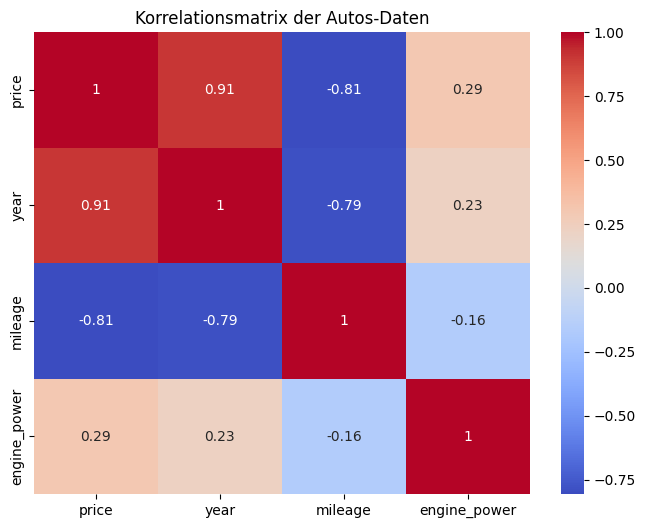

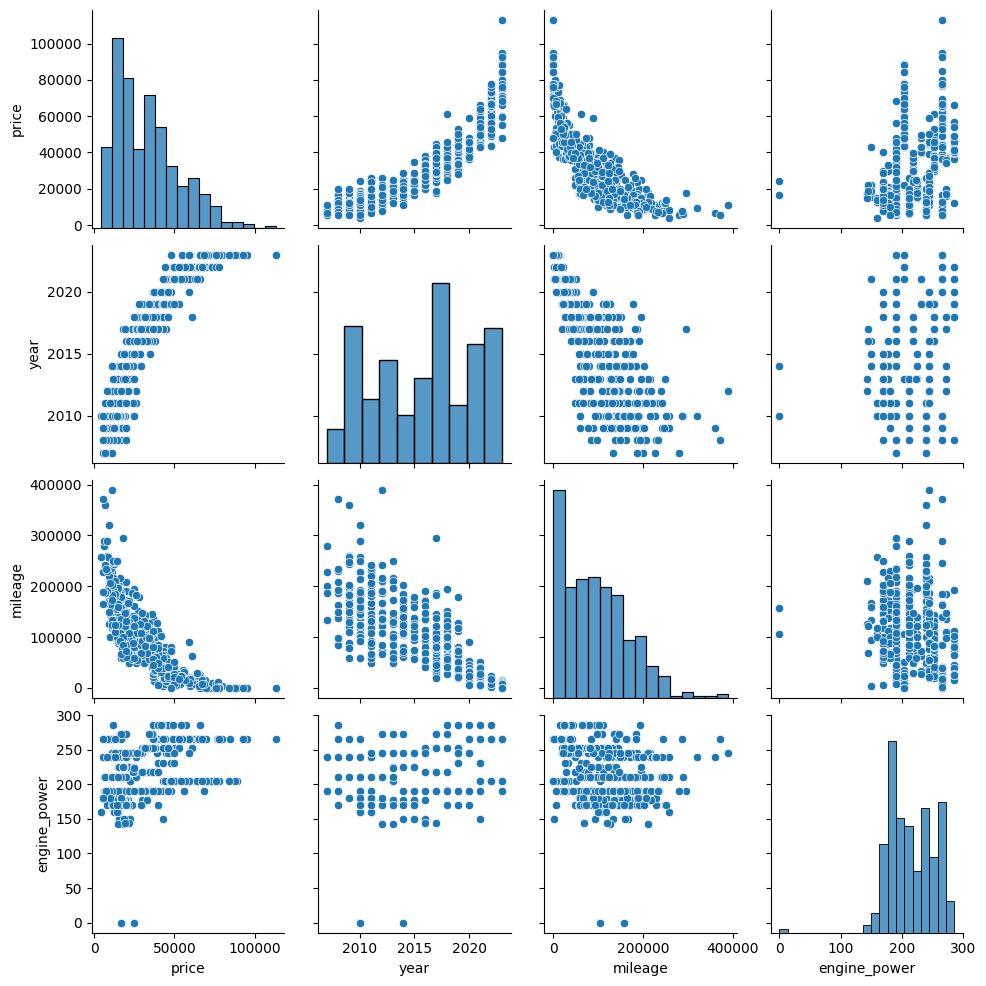

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Daten vorbereiten
autos_df = pd.DataFrame(data, columns=['id', 'model', 'price', 'currency', 'year', 'adress', 'mileage', 'fuel_type', 'engine_power'])
autos_df['price'] = autos_df['price'].astype(float)
autos_df['year'] = autos_df['year'].replace(['Neues Fahrzeug', 'Vorführmodell'], '01.2023')  # Ersetzen von "Neues Fahrzeug" und "Vorführmodell" durch "01.2023"
autos_df['year'] = pd.to_datetime(autos_df['year'], format="%m.%Y").dt.year
autos_df['mileage'] = autos_df['mileage'].str.replace("'", "").astype(float)
autos_df['engine_power'] = autos_df['engine_power'].replace('N/A', np.nan).astype(float)  # Ersetzen von "N/A" durch "NaN"

# Korrelationsmatrix erstellen
correlation_matrix = autos_df[['price', 'year', 'mileage', 'engine_power']].corr()
print(correlation_matrix)

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der Autos-Daten')
plt.show()

# Streudiagramme erstellen
sns.pairplot(autos_df[['price', 'year', 'mileage', 'engine_power']])
plt.show()



In [12]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Daten vorbereiten
autos_df1 = autos_df.drop(columns=['id', 'currency'])  # ID und Währung entfernen

# 'Neues Fahrzeug' und 'Vorführmodell' durch das aktuelle Jahr ersetzen
autos_df1['year'] = autos_df1['year'].replace(['Neues Fahrzeug', 'Vorführmodell'], '01.2023')

# Daten in numerische Werte umwandeln
autos_df1['year'] = pd.to_datetime(autos_df1['year'], format="%m.%Y").dt.year
autos_df1['mileage'] = autos_df1['mileage'].str.replace("'", "").astype(float)
autos_df1['engine_power'] = autos_df1['engine_power'].replace('N/A', np.nan).astype(float)

# Entfernen der Zeilen mit fehlenden Werten
autos_df1 = autos_df1.dropna()

# Teilen der Daten in Trainings- und Testdaten
X = autos_df1.drop('price', axis=1)
y = autos_df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konvertieren der Zielvariablen in Floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Vorverarbeitung der Daten
numeric_features = ['year', 'mileage', 'engine_power']
categorical_features = ['model', 'adress', 'fuel_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# CSR-Matrix in NumPy-Array umwandeln
X_train = X_train.toarray()
X_test = X_test.toarray()

# Neuronales Netzwerk erstellen
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Kompilieren des Modells
model.compile(loss='mean_squared_error', optimizer='adam')

# Modell trainieren
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Modell auf Testdaten evaluieren
mse_test = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {math.sqrt(mse_test)}')





Epoch 1/100
20/20 [==============================] - 1s 10ms/step - loss: 1554915200.0000 - val_loss: 1419980160.0000
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1554693248.0000 - val_loss: 1419568640.0000
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1553806464.0000 - val_loss: 1417976320.0000
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 1550642944.0000 - val_loss: 1413069312.0000
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1541842048.0000 - val_loss: 1400792192.0000
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 1521406464.0000 - val_loss: 1374854528.0000
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1482172416.0000 - val_loss: 1326797184.0000
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 1413080320.0000 - val_loss: 1247956864.0000
Epoch 9/100
20/20 [==============================] - 0s 4ms/ste